# Práctica 2

Autor: Zhengkai Zhu\
Grupo: Arquitectura y Prgramación de Computadores Cuánticos

## Ejercicio 1: Teleportacion Cuántica

Para empezar las importaciones de librerias necesarias

In [1]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram, array_to_latex, plot_bloch_multivector
from qiskit.circuit.library import Initialize
from qiskit.quantum_info import random_statevector
import numpy as np

#### ¿Cómo inicializo el qubit de Alice?

In [29]:
psi = random_statevector(2)
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
init_gate = Initialize(psi)
init_gate.label = 'init_Gate'
init_gate_inverse = init_gate.gates_to_uncompute()

q0_modulo = np.abs(psi[0])
q1_modulo = np.abs(psi[1])
print("Probabilidad de medir |0⟩ es: ",  q0_modulo**2)
print("Probabilidad de medir |1⟩ es: ", q1_modulo**2)



<IPython.core.display.Latex object>

Probabilidad de medir |0⟩ es:  0.8829788563647492
Probabilidad de medir |1⟩ es:  0.11702114363525085


Quiero inicializar el qubit de Alice a un estado inicial para probar que la teleportación cuántica que he implementado funciona correctamente.

Para empezar utilizo la funcion $random\_statevector(dimension)$ para crear un vector con estado random que luego me permite añadirlo a un qubit.

Con el constructor $Initialize(statevector)$ me permite crear una puerta que me inicialice un qubit al estado que inidica el state vector.\
Como el estado inicial de los qubits es $\ket{0}$ al aplicar "init_gate" el estado pasa a ser: $\ket{\psi}$

Con el fin de saber que se ha realizado correctemente la teleportacion, al final del circuito voy a aplicar la inversa de "init_gate" y medir el qubit de Bob. Tendría que salir $\ket{0}$ si se ha realizado correctamente la teleportacion.

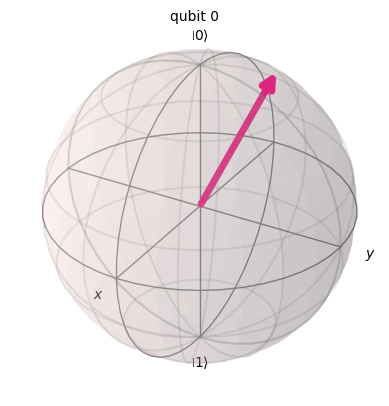

In [30]:
plot_bloch_multivector(psi)

Aqui muestro cómo quedaria en la esfera de bloch ese estado inicial random

#### Implementacion del Circuito

C:\Users\zheng\AppData\Local\Temp\ipykernel_13220\1710626124.py:31: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  teleport_circuit.x(qreg[2]).c_if(creg[1], 1) # Aplico una X si el bit al medir qreg[1] obtenemos un 1
C:\Users\zheng\AppData\Local\Temp\ipykernel_13220\1710626124.py:32: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  teleport_circuit.z(qreg[2]).c_if(creg[0], 1) # Aplico una Z si el bit al medir qreg[0] obtenemos un 1


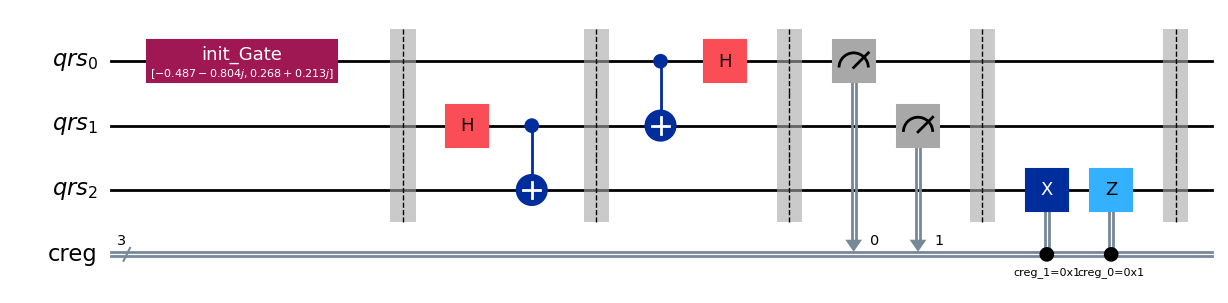

In [70]:
#Creamos los bits cuanticos y clasicos
qreg = QuantumRegister(3, 'qrs') # Creo los registros Q (qubit a teleportar), R (qubit auxiliar que tiene Alice) y S (qubit receptor de Q)
creg = ClassicalRegister(3, 'creg')

#Creo el circuito cuantico para la teleportacion
teleport_circuit = QuantumCircuit(qreg, creg, name = 'Circuito_teleportacion')


#Paso 0: Inicializo el qubit a teleportar
teleport_circuit.append(init_gate, [0])
teleport_circuit.barrier()

#Paso 1: Creo el entrelazamiento de R y S que seran los qubits qreg[1] y qreg[2], respectivamente
teleport_circuit.h(qreg[1])
teleport_circuit.cx(qreg[1], qreg[2])

teleport_circuit.barrier()


#Paso 2: Realizamos medicion de Bell
teleport_circuit.cx(qreg[0], qreg[1])
teleport_circuit.h(qreg[0])
teleport_circuit.barrier()

#Paso 3: Medimos los qubits de Alice
teleport_circuit.measure(qreg[0], creg[0])
teleport_circuit.measure(qreg[1], creg[1])
teleport_circuit.barrier() 

#Paso 4: Realizamos las operaciones en el qubit de Bob para recuperar el estado Q original
teleport_circuit.x(qreg[2]).c_if(creg[1], 1) # Aplico una X si el bit al medir qreg[1] obtenemos un 1
teleport_circuit.z(qreg[2]).c_if(creg[0], 1) # Aplico una Z si el bit al medir qreg[0] obtenemos un 1

teleport_circuit.barrier()


#teleport_circuit.measure(qreg[2], creg[2])

display(teleport_circuit.draw('mpl'))



Aqui he implementado el circuito de la teleportacion cuantica. 

Para empezar he creado los 3 bits cuanticos y los 3 bits clasicos, que me van a servir más adelante y los agregado al circuito cuantico que he creado.

Voy a considerar en este ejercicio el qubit 0 como el qubit a teleportar de Alice (qubit Q), el qubit 1 como el auxiliar que se queda Alice (qubit R), y por último el qubit 2 como el qubit de Bob de recepcion (qubit S).

- Paso 0: Para empezar he inicializado el qubit Q a $\ket{\psi}$ mediante la puerta que he creado en una de las celdas anteriores que permite introducir un estado random que he obtenido previamente. En el dibujo se ve el "init_Gate". 
$$\ket{\psi} = \alpha\ket{0} + \beta\ket{1}$$

- Paso 1: Como primer paso, voy a entrelazar el qubit de Bob (S) con el qubit auxiliar de Alice (R), aplicando primero una $Hadamard$ a R y luego tomando este como control, aplico una $CNOT$ con S como objetivo.\
De esta manera consigo el primer estado de Bell entre los qubits $\ket{Q_S Q_R}$: $$\ket{\phi^+} = \frac{1}{\sqrt2}(\ket{00} + \ket{11})$$
En este punto ya tenemos el siguiente estado: $\ket{\phi^+}\ket{\psi}$\
Quedaria de la siguiente manera: $$\ket{\phi^+}\ket{\psi} = \frac{1}{\sqrt2} (\alpha\ket{000} + \beta\ket{001} + \alpha\ket{110} + \beta\ket{111})$$

- Paso 2: En este paso realizo la medicion de Bell que se comenta en el enunciado de la practica. Consiste en aplicar una CNOT con el qubit Q (qreg[0]) como control y el qubit R (qreg[1]) como objetivo y luego le aplico una Hadamard.\
Voy a llamar al estado del conjunto $\ket{\gamma}$. 
Entonces me quedaria el siguiente estado:
$$\ket{\gamma} = \frac{1}{2}[(\alpha\ket{0} + \beta\ket{1})\ket{00} + (\alpha\ket{0} - \beta\ket{1})\ket{01} + (\beta\ket{0} + \alpha\ket{1})\ket{10} + (- \beta\ket{0} + \alpha\ket{1})\ket{11}]$$
(Recuerdo que el qubit menos significativo es el que origianalmente tenia el estado $\ket{\psi}$)\
Aqui vemos que dependiendo de lo que mida Alice en sus qubits, puede indicarle a Bob qué puerta tiene que aplicar a su qubit con tal de recuperar el estado $\ket{\psi}$

- Paso 3: Medimos los dos qubits de Alice.

- Paso 4: Una vez Alice tiene la medición de sus qubits, Bob tiene que aplicar lo siguiente:
    - Si mide en qreg[0], que es Q, un 1, Bob tiene que aplicar una $X$ a su qubit. Es para los casos que mida: $\ket{01} y \ket{11}$.
    - Si mide en qreg[1], que es R, un q, Bob tiene que aplicar una puerta $Z$ a su qubit. Es para los casos que mida $\ket{10} y \ket{11}$


De esta manera Bob tiene el qubit que Alice quería enviarle. 
Ahora veamos si el circuito realmente funciona

#### Simulacion con QASMSimulator

Para realizar la simulacion con el QASMSimulator de Aer, he añadido al final del circuito la medicion del qubit de Bob, para saber qué vamos obteniendo.

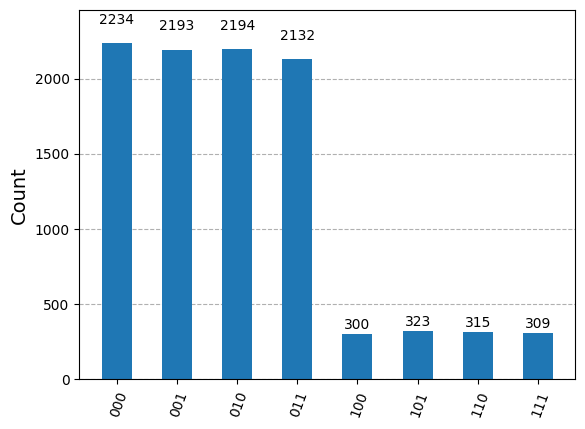

In [69]:
#Simulamos el circuito cuantico
backend_qasm1 = Aer.get_backend('qasm_simulator')
transpiled_circuit = transpile(teleport_circuit, backend_qasm1, optimization_level = 1)
job1 = backend_qasm1.run(transpiled_circuit, shots=10000) 
result1 = job1.result()
counts = result1.get_counts(teleport_circuit)
display(plot_histogram(counts))

En esta ejecucion determinada, el estado incial de $\ket{\psi}$ es el que se ve más arriba cuando genero el estado random para el qubit de Alice.\
En este estado en concreto, el qubit de Alice tenia un $88.3\%$ probabilidades de medir $\ket{0}$ y un $11.7\%$ de probabilidades de medir un $\ket{1}$.

Para realizar la simulacion he realizado 10000 shots con tal de que se vea más claro las diferencias. 

Después de ejecutar todo el circuito de teleportación, podemos ver en el gráfico las probabilidades al medir Bob su qubit.\
Vamos a ver el caso en el que Alice mide en sus dos qubits un $\ket{00}$, que son las dos columnas $\ket{000} y \ket{100}$ del grafico (los qubits de Alice son los menos significativos).\
Vemos que cuando Alice mide $\ket{00}$ (un total de 2534 veces), al medir el qubit de Bob se obtiene 2234 veces un $\ket{0}$ y luego 300 veces un $\ket{1}$\
De las 2234 veces que Alice mide $\ket{00}$:
- 2234 veces se ha medido $\ket{0}$ que representa el $88.16\%$ de las veces.
- 300 veces se ha medido $\ket{1}$ que representa el $11.84\%$ de las veces.

Con esto queda claro que el circuito en la simulacion se comporta correctamente.

Ahora, que las probabilidades de medir una cosa u otra se cumpla no todavía una prueba fehaciente de que el estado se ha teleportado de manera correcta. A lo mejor Bob en vez del estado $\alpha\ket{0} + \beta\ket{1}$ ha recibido un estado $\alpha\ket{0} - \beta\ket{1}$. \
Para estar completamente seguros, voy a simularlo pero mostrando el estado final del circuito, que es el segundo método de simulacion que voy a utilizar, la simulacion con StateVectorSimulator.

#### Simulacion con StateVectorSimulator

En este método de simulacion voy a mostrar el estado que recibe Bob en la esfera de Bloch, que es la misma del estado de Alice al principio

In [71]:
backend_statevector1 = Aer.get_backend('statevector_simulator')
job1 = backend_statevector1.run(teleport_circuit)
result1 = job1.result()
final_state1 = result1.get_statevector()


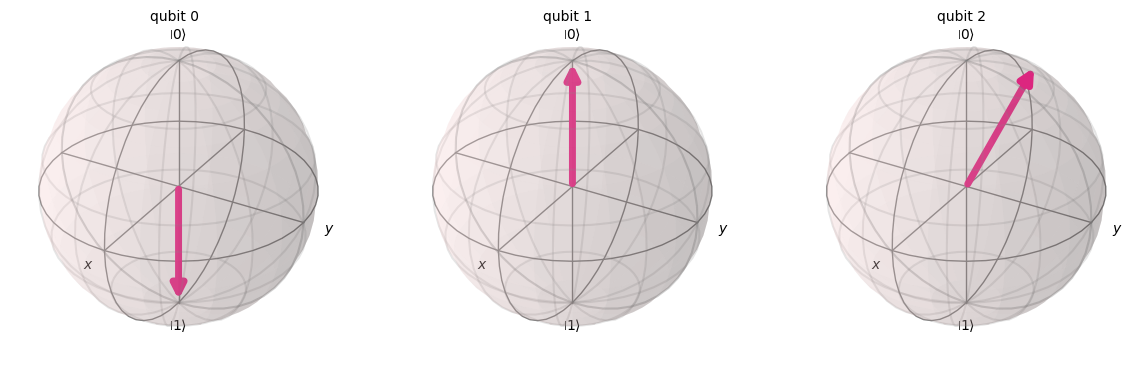

In [72]:
plot_bloch_multivector(final_state1)

Al principio del ejercicio, al crear el estado aleatorio que le he asignado como estado inicial al qubit de Alice, he mostrado cómo quedaría dicho estado en la esfera de Bloch.

Tras simular el circuito (quitando la medicion final del qubit de Bob), podemos ver que el qubit de Bob está en el miso estado que el de Alice.
Se puede ver en la esfera de Bloch del qubit 2.

Si lo simulas varias veces, los qubit 0 y 1 van alternando entre $\ket{0} y \ket{1}$, pero el qubit de Bob siempre acaba en ese estado.

Con esto vemos, que el circuito funciona correctamente.

## Ejercicio 2: Codificacion Superdensa

Para realizar la codificacion superdensa, para empezar voy a generar de manera aleatoria los dos bits clasicos de Alicia. Para ello voy a utilizar dos qubits auxiliares a los que voy a aplicar puertas H y luego medirlos sobre dos registros clasicos.

C:\Users\zheng\AppData\Local\Temp\ipykernel_13220\2138782229.py:30: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  codSuperdensa_circuit.x(qregCodDensa[0]).c_if(cregB, 1)  #Aplico una X sobre el qubit del par Epr que tiene Alice si el bit B es 1
C:\Users\zheng\AppData\Local\Temp\ipykernel_13220\2138782229.py:31: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  codSuperdensa_circuit.z(qregCodDensa[0]).c_if(cregA, 1)  #Aplico una Z sobre el qubit del par Epr que tiene Alice si el bit A es 1


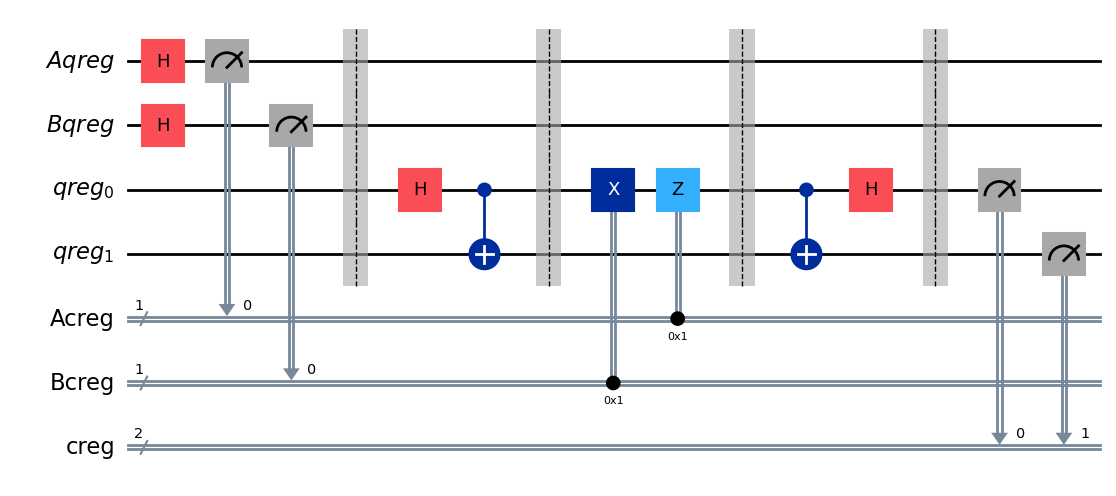

In [73]:
#Esto son los registros para codificar los 2 bits clasicos de Alice.
qregA = QuantumRegister(1, 'Aqreg') #Qubit menos significativo
qregB = QuantumRegister(1, 'Bqreg') #Qubit mas significativo

cregA = ClassicalRegister(1, 'Acreg') #Bit menos significativo
cregB = ClassicalRegister(1, 'Bcreg') #Bit mas significativo


#A partir de aqui empieza las partes del circuito de verdad
qregCodDensa = QuantumRegister(2, 'qreg') #Qubits de Bob 
cregCodDensa = ClassicalRegister(2, 'creg') #Los bits clasicos sobre los que voy a medir los qubits de Bob


codSuperdensa_circuit = QuantumCircuit(qregA, qregB,  qregCodDensa, cregA, cregB, cregCodDensa, name = 'Circuito_codificacion_superdensa')

#Parte 0: Inicializo los bits que quiere transmitir de Alice
codSuperdensa_circuit.h(qregA[0])
codSuperdensa_circuit.h(qregB[0])
codSuperdensa_circuit.measure(qregA[0], cregA[0])
codSuperdensa_circuit.measure(qregB[0], cregB[0])
codSuperdensa_circuit.barrier()

#Parte 1: Creo el par epr entre los qubits de Bob
codSuperdensa_circuit.h(qregCodDensa[0])
codSuperdensa_circuit.cx(qregCodDensa[0], qregCodDensa[1])
codSuperdensa_circuit.barrier()


#Parte 2: Aplico las compuertas necesarias para codificar los bits de Alice
codSuperdensa_circuit.x(qregCodDensa[0]).c_if(cregB, 1)  #Aplico una X sobre el qubit del par Epr que tiene Alice si el bit B es 1
codSuperdensa_circuit.z(qregCodDensa[0]).c_if(cregA, 1)  #Aplico una Z sobre el qubit del par Epr que tiene Alice si el bit A es 1
codSuperdensa_circuit.barrier()

#Supongo que Alice envia el qubit 0 a Bob por un canal cuantico.
#Parte 3: Bob aplica las puertas para decodificar los bits de Alice
codSuperdensa_circuit.cx(qregCodDensa[0], qregCodDensa[1])
codSuperdensa_circuit.h(qregCodDensa[0])
codSuperdensa_circuit.barrier()


codSuperdensa_circuit.measure(qregCodDensa[:], cregCodDensa[:])

display(codSuperdensa_circuit.draw('mpl'))


Para este ejercicio he seguido los pasos indicados en el enunciado de la practica.\
Pero antes de nada necesito que Alice tenga dos bits clasicos en un estado y que sea ese el que transmita.

Con este fin, primero he preparado esos dos bits clasicos que Alice quiere enviar, y para explorar todas las posibilidades he creado los dos qubits auxliliares $\ket{Qbit_B Qbit_A}$. A ambos qubits que estan a 0 inicialmente les aplico una Hadamard para obtener un estado de superposicion con todas las posibilidades de estados con 2 bits: $\ket{Qbit_B Qbit_A} = \frac{1}{2}(\ket{00} + \ket{01} + \ket{10} + \ket{11})$. 

Luego colapso estos dos qubits midiéndolos y los guardo en los bits clasicos A (menos significativo) y B (más significativo). \
De esta forma tengo dos bits clásicos, que serán los que Alice va a transmitir a Bob.

Toda esta preparación es para comprobar que el circuito de la Codificación Superdensa funciona correctamente.

- Paso 0: Preparo los bits clásicos de Alice, que va a transmitir, tal y como he explicado previamente.
- Paso 1: Aqui empieza el circuito de la Codificación Superdensa.\
Primero aclaro que el qubit del par EPR que tiene Alice y que va a enviar a Bob es el menos significativo. Lo comento porque esto implica que la aplicación de puertas del siguiente paso va a ser al revés del que se comenta en el enunciado de la práctica.\
Entonces, creo un par EPR (ya se ha explicado en previos ejercicios cómo se realiza, que es con una puerta Hadamard y una CNOT).
$$\ket{\phi_1} = \frac{1}{\sqrt2}(\ket{00} + \ket{11})$$
- Paso 2: Alice tiene el qubit 0 que es el menos significativo, por tanto ella aplicará las operaciones a este qubit, dependiendo de los bits clásicos que tiene:
    - Si el bit B == 1 entonces aplico una X sobre el qubit 0. 
    - Si el bit A == 1 entonces aplico una Z sobre el qubit 0.

Vemos los casos posibles. Si Alice tiene:
1) (00) $\Rightarrow$ $\ket{\phi_2} = \frac{1}{\sqrt2}(\ket{00} + \ket{11})$
2) (01) $\Rightarrow$ $\ket{\phi_2} = \frac{1}{\sqrt2}(\ket{00} - \ket{11})$
3) (10) $\Rightarrow$ $\ket{\phi_2} = \frac{1}{\sqrt2}(\ket{01} + \ket{10})$
4) (11) $\Rightarrow$ $\ket{\phi_2} = \frac{1}{\sqrt2}(-\ket{01} + \ket{10})$

- Paso 3: Supongamos que Alice le ha enviado por un canal cuántico $q0$.\
Ya en este paso "deshacemos" el par EPR aplicando una CNOT con $q0$ de control y $q1$ de objetivo. Finalmente una Hadamard a $q0$.\
En el paso anterior, para cada posible estado clásico que tenga Alice, Bob obtiene el estado de Bell asociado.\
Por tanto, tras deshacerlo, Bob recibe los bit clásicos de Alice.

Con el fin de que la simulacion se vea mejor, he añadido la medicion de los qubits de Bob. Así podemos ver en el historigrama de la simulacion con QASMSimulator cómo funciona correctamente el circuito.


#### Simulación con QASMSimulator

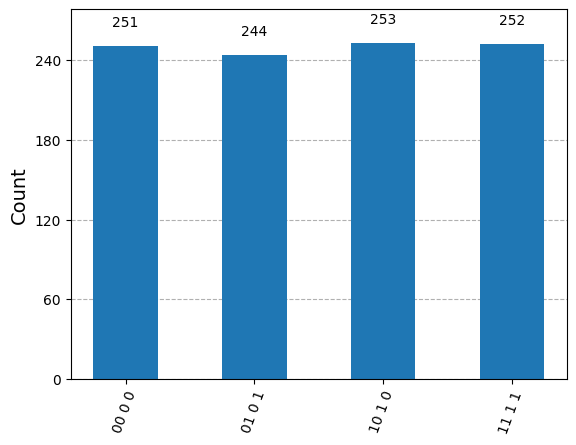

In [75]:
backend_qasm2 = Aer.get_backend('qasm_simulator')
transpiled_circuit2 = transpile(codSuperdensa_circuit, backend_qasm2, optimization_level = 1)
job2 = backend_qasm2.run(transpiled_circuit2, shots=1000)
result2 = job2.result()
counts2 = result2.get_counts(codSuperdensa_circuit)
display(plot_histogram(counts2))

Con este gráfico se observa que al simular solo se puede obtener los siguientes cuantro estados:
- $\ket{0000}$
- $\ket{0101}$
- $\ket{1010}$
- $\ket{1111}$

Los dos bits menos significativos son los bits de Alice y los dos más significativos son los de Bob.

Se observa que el circuito funciona correctamente, pues cuando Alice tiene un estado, Bob obtiene el mismo


#### Simulacion con StateVectorSimulator

En esta parte voy a simularlo con el StateVectorSimulator, que me permite obtener una ilustracion de las esferas de Bloch

In [88]:
backend_statevector2 = Aer.get_backend('statevector_simulator')
job2 = backend_statevector2.run(codSuperdensa_circuit)
result2 = job2.result()
final_state2 = result2.get_statevector()

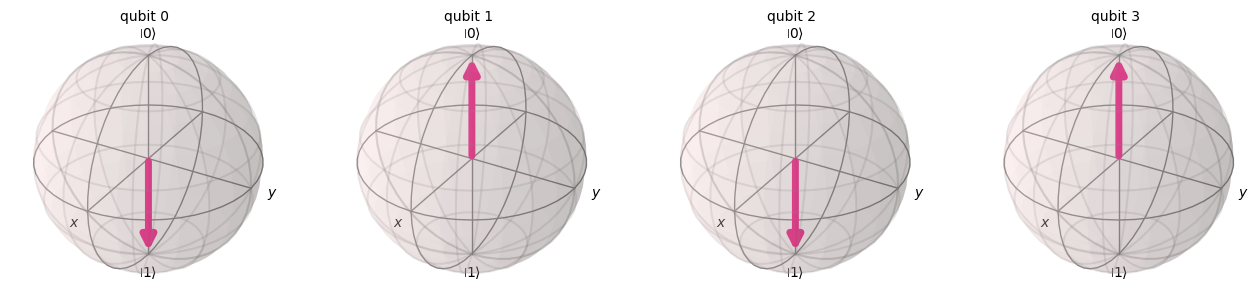

In [89]:
plot_bloch_multivector(final_state2)

Aquí también observamos que el circuito funciona correctamente.

$\ket{Q_1 Q_0}$ corresponde a los bits de Alice y $\ket{Q_3 Q_2}$ corresponde a los de Bob.
Vemos que ambos pares de qubits se encuentran en el mismo estado. 
No importa la de veces que se ejecute el circuito, siempre son iguales.

Concluimos que el circuito funciona correctamente

## Ejercicio 3: Backends reales

El problema de backends reales, no podemos realizar mediciones en mitad del circuito. Tenemos que atrasar las mediciones hasta el final y no debería afectar al funcionamiento del circuito.

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

token = ""

### Ejercicio 3.1: Para el caso de teleportación

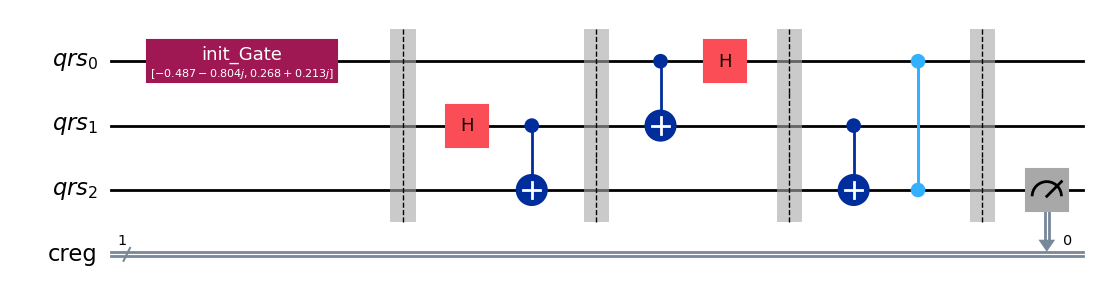

In [99]:
#Creamos los bits cuanticos y clasicos
qreg = QuantumRegister(3, 'qrs') # Creo los registros Q (qubit a teleportar), R (qubit auxiliar que tiene Alice) y S (qubit receptor de Q)
creg = ClassicalRegister(1, 'creg')

#Creo el circuito cuantico para la teleportacion
teleport_circuit = QuantumCircuit(qreg, creg, name = 'Circuito_teleportacion')


#Paso 0: Inicializo el qubit a teleportar
teleport_circuit.append(init_gate, [0])
teleport_circuit.barrier()

#Paso 1: Creo el entrelazamiento de R y S que seran los qubits qreg[1] y qreg[2], respectivamente
teleport_circuit.h(qreg[1])
teleport_circuit.cx(qreg[1], qreg[2])

teleport_circuit.barrier()


#Paso 2: Realizamos medicion de Bell
teleport_circuit.cx(qreg[0], qreg[1])
teleport_circuit.h(qreg[0])
teleport_circuit.barrier()

#teleport_circuit.measure(qreg[0], creg[0])
#teleport_circuit.measure(qreg[1], creg[1])
#teleport_circuit.barrier() 

#Paso 3: Realizamos las operaciones en el qubit de Bob para recuperar el estado Q original
teleport_circuit.cx(qreg[1], qreg[2]) 
teleport_circuit.cz(qreg[0], qreg[2])

teleport_circuit.barrier()

teleport_circuit.measure(qreg[2], creg[0])

#teleport_circuit.measure(qreg[2], creg[2])

display(teleport_circuit.draw('mpl'))

Con el fin de que se puede ejectar correctamente el circuito en un computador real, cambio las CNOT y CZ donde el control esta en bits clasicos, por los CNOT y CZ sobre qubits. Teóricamente no debería afectar al funcionamiento del circuito. 

Al final, el circuito se mantiene casi igual que el original, solo que elimino las mediciones de los qubits de Alice y solo mantengo la medición del qubit de Bob solo para ver los resultados al ejecutarlo y ver qué valores vamos obteniendo

Ahora ejecutamos en una backend real de IBM, siguiendo el procedimiento explicado en la Práctica 1.

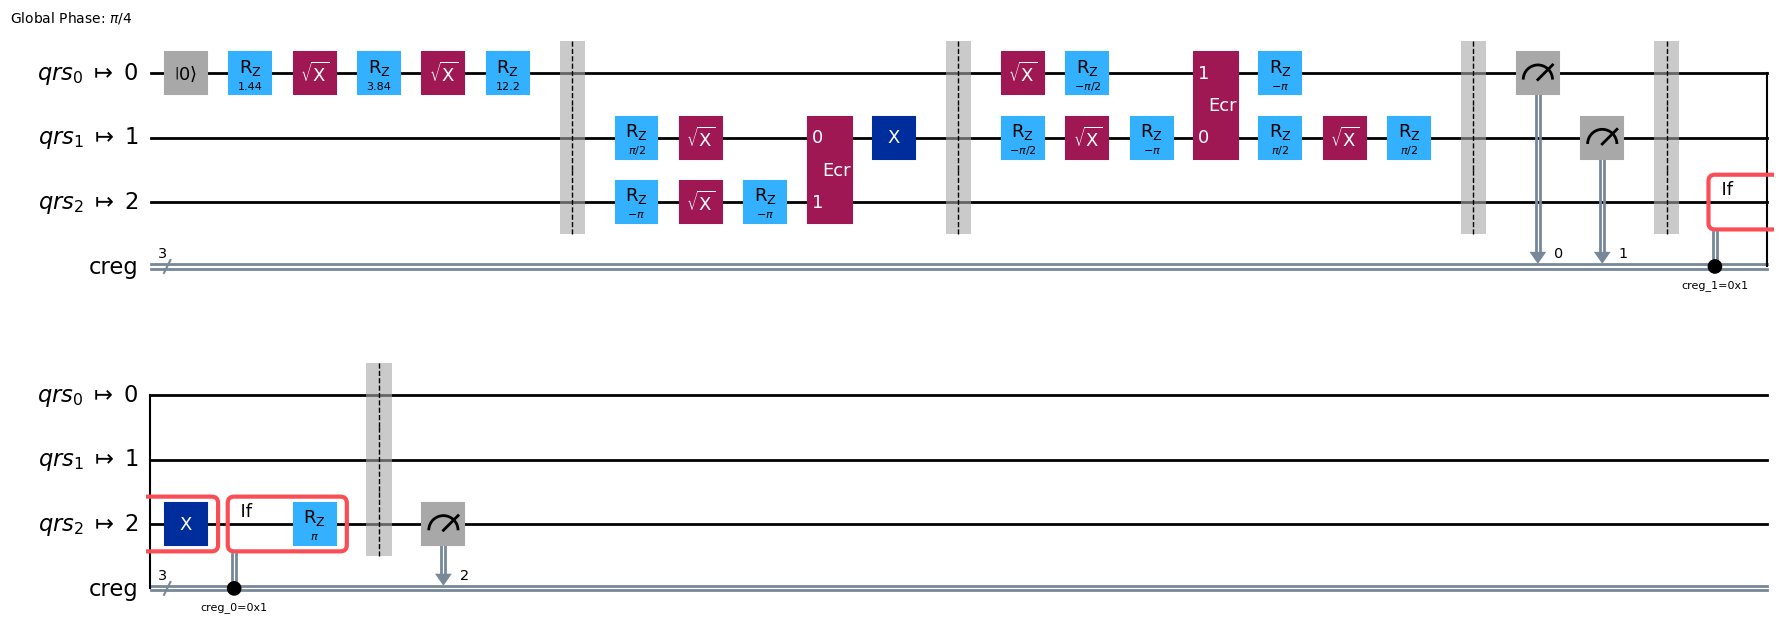

In [101]:
service = QiskitRuntimeService(channel="ibm_quantum", token=token)
backend = service.least_busy(simulator=False, operational=True)

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(transpiled_circuit)

#Mostramos el circuito compilado al computador cuántico real
isa_circuit.draw("mpl", idle_wires=False)

job id: czbj2284spc000872psg
{'010': 1979, '011': 2059, '101': 512, '001': 1996, '111': 611, '000': 1939, '110': 556, '100': 348}


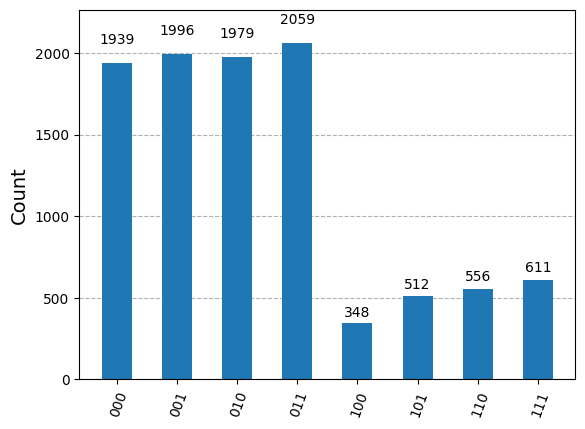

In [102]:
#Ejecutamos el circuito en el computador cuántico real
sampler = Sampler(backend)
job = sampler.run([isa_circuit], shots=10000)
print(f"job id: {job.job_id()}")
result = job.result()

#Mostramos los resultados
for item in result._pub_results[0].data.items():
    print(item[1].get_counts())
    display(plot_histogram(item[1].get_counts()))

Al igual que en la simulación, para poder diferenciar bien las probabilidades, he realizado 10000 shots del circuito en el computador cuántico real.

Como se puede observar en el gráfico se ha obtenido una distribucion de estados muy parecido al de la simulacion.

Alice tenía un estado incial donde es mucho más probable obtener el estado $\ket{0}$ que el estado $\ket{1}$, tal y como se observa en la gráfica. Debemos fijarnos en el qubit más significativo que es el qubit de Bob y vemos que obtiene el mismo estado que Alice.

### Ejercicio 3.2: Para el caso de codificacion superdensa

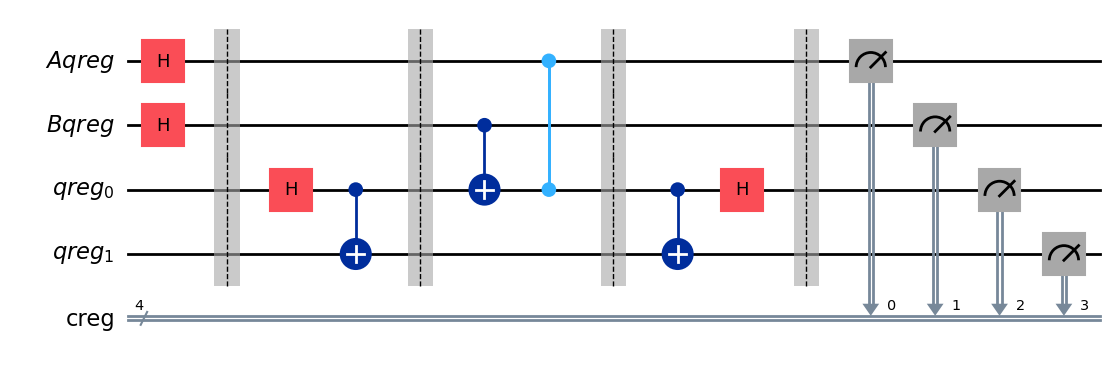

In [106]:
#Esto son los registros para codificar los 2 bits clasicos de Alice.
qregA = QuantumRegister(1, 'Aqreg') #Qubit menos significativo
qregB = QuantumRegister(1, 'Bqreg') #Qubit mas significativo

cregA = ClassicalRegister(1, 'Acreg') #Bit menos significativo
cregB = ClassicalRegister(1, 'Bcreg') #Bit mas significativo


#A partir de aqui empieza las partes del circuito de verdad
qregCodDensa = QuantumRegister(2, 'qreg') #Qubits de Bob 
cregTotal = ClassicalRegister(4, 'creg') #Los bits clasicos sobre los que voy a medir los qubits de Bob


codSuperdensa_circuit = QuantumCircuit(qregA, qregB,  qregCodDensa, cregTotal, name = 'Circuito_codificacion_superdensa')

#Parte 0: Inicializo los bits que quiere transmitir de Alice
codSuperdensa_circuit.h(qregA[0])
codSuperdensa_circuit.h(qregB[0])

codSuperdensa_circuit.barrier()

#Parte 1: Creo el par epr entre los qubits de Bob
codSuperdensa_circuit.h(qregCodDensa[0])
codSuperdensa_circuit.cx(qregCodDensa[0], qregCodDensa[1])
codSuperdensa_circuit.barrier()


#Parte 2: Aplico las compuertas necesarias para codificar los bits de Alice
codSuperdensa_circuit.cx(qregB[0], qregCodDensa[0])
codSuperdensa_circuit.cz(qregA[0], qregCodDensa[0])  
codSuperdensa_circuit.barrier()

#Supongo que Alice envia el qubit 0 a Bob por un canal cuantico.
#Parte 3: Bob aplica las puertas para decodificar los bits de Alice
codSuperdensa_circuit.cx(qregCodDensa[0], qregCodDensa[1])
codSuperdensa_circuit.h(qregCodDensa[0])
codSuperdensa_circuit.barrier()


codSuperdensa_circuit.measure(qregA[0], cregTotal[0])
codSuperdensa_circuit.measure(qregB[0], cregTotal[1])
codSuperdensa_circuit.measure(qregCodDensa[0], cregTotal[2])
codSuperdensa_circuit.measure(qregCodDensa[1], cregTotal[3])

display(codSuperdensa_circuit.draw('mpl'))

Para la Codificación Superdensa también atraso todas las mediciones hasta el final, hasta las mediciones para los bits clásicos iniciales de Alice.

He juntado los bits de Alice con los bits tras medir de Bob en un mismo registro de 4 bits clásicos. Así al ejecutar y dibujar el histograma me saldría como en la simulacion o algo muy parecido con los bits juntos.


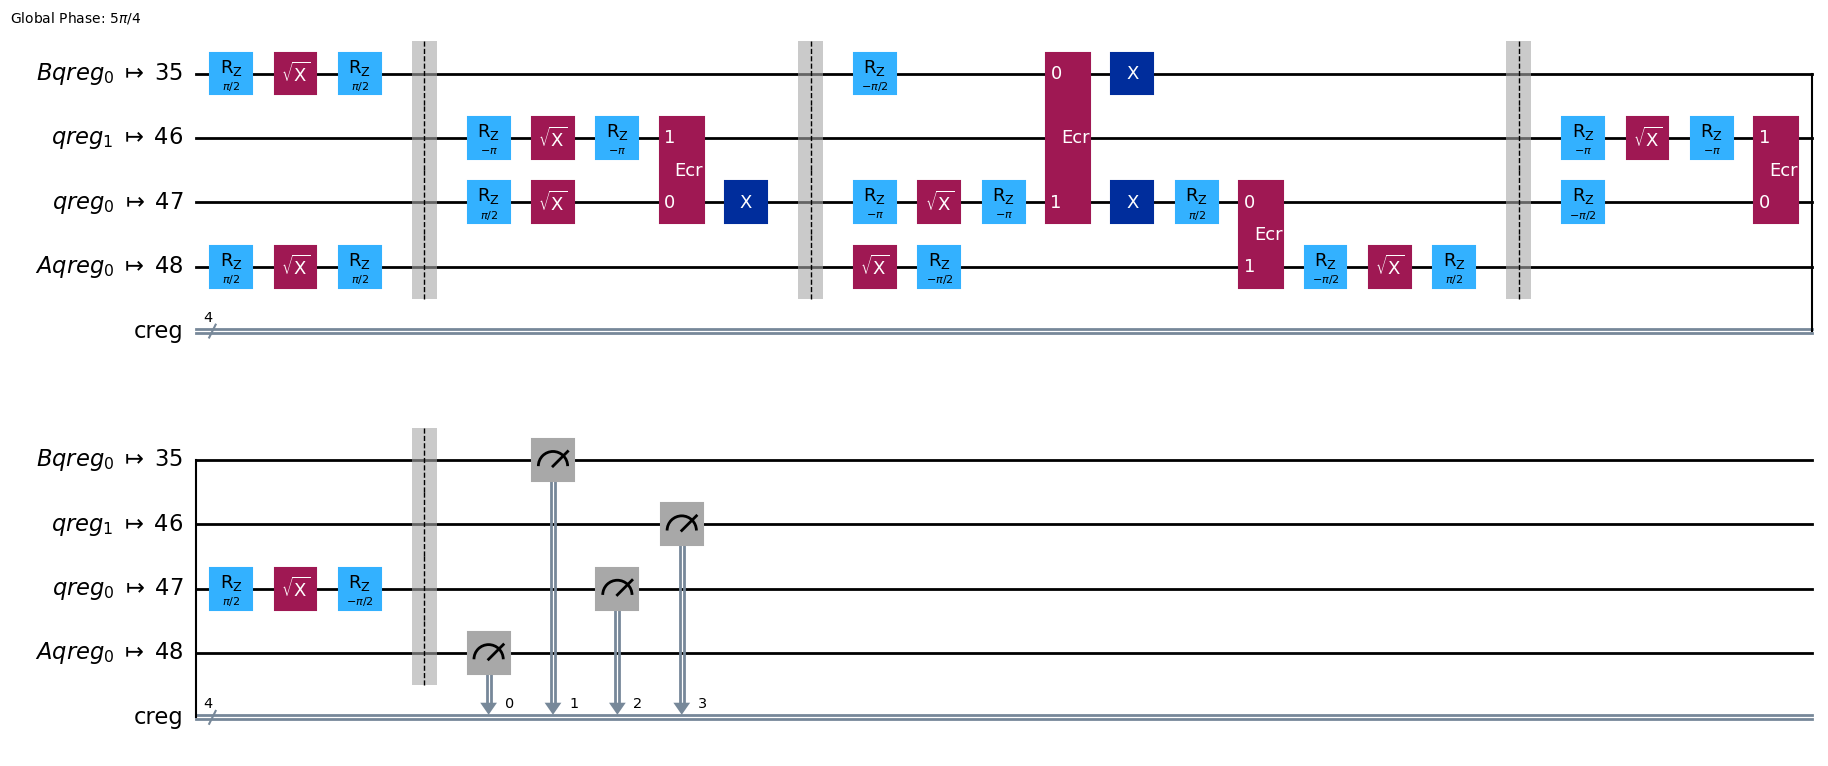

In [107]:
service2 = QiskitRuntimeService(channel="ibm_quantum", token=token)
backend2 = service2.least_busy(simulator=False, operational=True)

pm2 = generate_preset_pass_manager(backend=backend2, optimization_level=1)
isa_circuit2 = pm2.run(codSuperdensa_circuit)

#Mostramos el circuito compilado al computador cuántico real
isa_circuit2.draw("mpl", idle_wires=False)

job id: czbj4dhqadq0008cf770
{'1101': 4, '0101': 205, '1010': 240, '0000': 267, '0010': 16, '1111': 208, '1100': 2, '0011': 3, '0001': 10, '0111': 11, '1000': 10, '1011': 12, '1110': 6, '0100': 4, '1001': 1, '0110': 1}


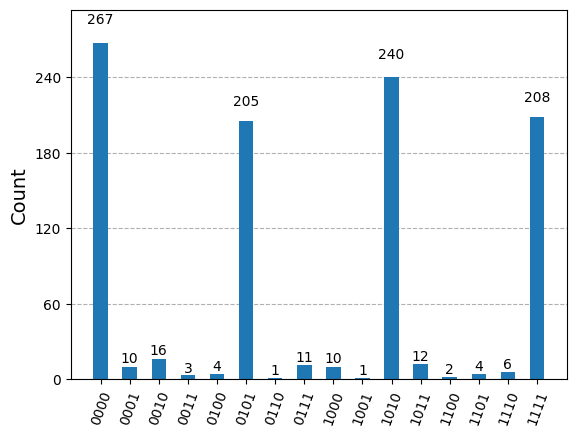

In [108]:
sampler2 = Sampler(backend2)
job2 = sampler2.run([isa_circuit2], shots=1000)
print(f"job id: {job2.job_id()}")
result2 = job2.result()

#Mostramos los resultados
for item in result2._pub_results[0].data.items():
    print(item[1].get_counts())
    display(plot_histogram(item[1].get_counts()))

Después de ejecutar el circuito, vemos que los estados mayoritarios son los siguientes:
- $\ket{0000}$
- $\ket{0101}$
- $\ket{1010}$
- $\ket{1111}$

Que son los que necesito para saber que la Codificación Superdensa ha funcionado, tal y como he explicado en el ejercicio 2.

También tenemos estados minoritarios, pero esos no hay que tenerlos en cuenta, pues son fruto de diferentes errores que va afectando al computador cuántico real. Nos muestra que en la realidad no obtenemos mediciones tan exactas como en la simulación. 